# Algorytm najszybszego spadku dla regresji wielomianowej. 

Skład grupy:
- Nowak Ania,
- Łaźna Patrycja,
- Bregier Damian

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

## 0. Podstawowe informacje o zbiorze danych

Ze względu na specyfikę wytycznych projektu zakładającego wykorzystanie jedynie dwóch cech: x i y oraz modelowanie zależności y od x za pomocą funkcji wielomianowej dobrany został przez nas odpowiedni dataset. Obejmuje on jedynie trzy kolumny, czyli: płeć, wzrost w calach oraz wagę w funtach, z czego ze względu na specyfikę projektu wykorzystywane są jedynie wzrost oraz waga. Każdy z parametrów zawiera po 10 tysięcy unikalnych wartości.

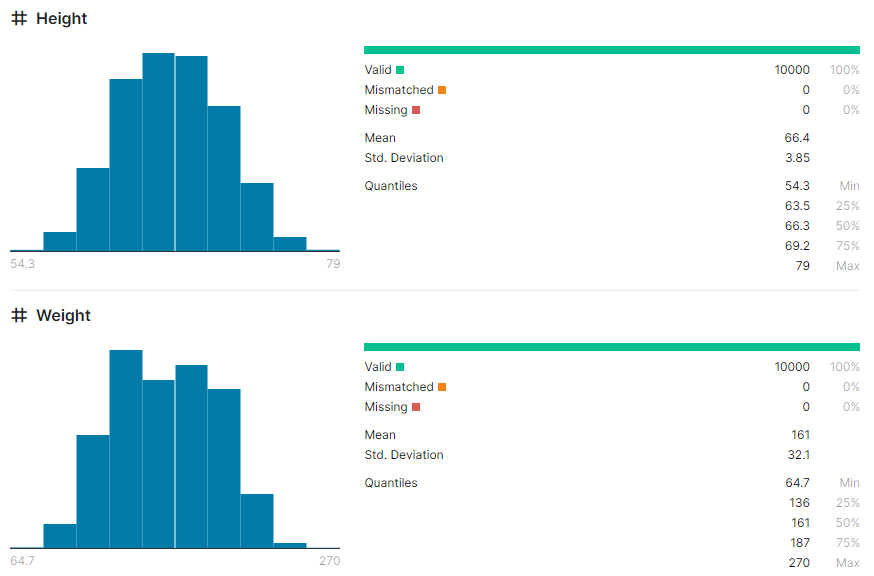

## 1. Wczytywanie i preprocessing danych

In [2]:
# Stopień wielomianu
degree = 4
X_plot = np.linspace(0, 100, 1000)
initial_theta = np.matrix([0] * (degree + 1)).reshape(degree + 1, 1)

In [3]:
# Wybór dwóch kolumn - dotyczących wzrostu i wagi
data = pd.read_csv('weight-height.csv')[["Height", "Weight"]]
# Czyszczenie tabeli i wartości pustych
data = data.dropna()
data_matrix = np.matrix(data)

m, n_plus_1 = data_matrix.shape
n = n_plus_1 - 1
X = (np.ones((m, 1)))

for i in range(1, degree + 1):
    Xn = np.power(data_matrix[:, 0:n], i)
    Xn /= np.amax(Xn, axis=0)
    X = np.concatenate((X, Xn), axis=1)

X = np.matrix(X).reshape(m, degree * n + 1)
Y = np.matrix(data_matrix[:, -1])

## 2. Metody do regresji wielomianowej

In [4]:
# Implementacja wzrosu na regresję wielomianową
def polynomial_regression(theta, x):
    x = x/data["Height"].max()
    return sum(theta * np.power(x, i) for i, theta in enumerate(theta.tolist()))

# Implementacja wzoru na RMSE, czyli pierwiastek z błędu średniokwadratowego
def mean_squared_error(theta, X, Y):
    J = 1.0 / (2.0 * m) * ((X * theta - Y).T * (X * theta - Y))
    return J.item()

# Wzór na gradient prosty
def gradient(theta, X, Y):
    return 1.0 / len(Y) * (X.T * (X * theta - Y)) 

# Batch gradient descent (BGD)
def BGD(X, Y, theta, cost_function = mean_squared_error, alpha=0.1, eps=10**-5, max_steps = 10000000000):
    cost = cost_function(theta, X, Y)
    logs = [[cost, theta]]
    
    for i in range(max_steps):
        theta = theta - alpha * gradient(theta, X, Y)
        next_cost = cost_function(theta, X, Y)
        logs.append([next_cost, theta])
        if abs(cost - next_cost) <= eps:
            break
        cost = next_cost
    return theta, logs

# Batch gradient descent (BGD)
def steepest_descent(X, Y, theta, cost_function = mean_squared_error, eps=10**-5, max_steps = 10000000000):
    cost = cost_function(theta, X, Y)
    logs = [[cost, theta]]
    
    for i in range(max_steps):
        theta = theta - alpha * gradient(theta, X, Y)
        next_cost = cost_function(theta, X, Y)
        logs.append([next_cost, theta])
        if abs(cost - next_cost) <= eps:
            break
        cost = next_cost
    return theta, logs

# Mini-batch gradient descent (MBGD)
def MBGD(X, Y, theta, cost_function = mean_squared_error, alpha=0.1, epochs=5, batch_size=16):
    cost = cost_function(theta, X, Y)
    logs = [[cost, theta]]
    start, end = 0, batch_size
    
    steps = m / batch_size
    for i in range(epochs):
        zipped_XY = list(zip(X, Y))
        random.shuffle(zipped_XY)
        X_shuffled, Y_shuffled = zip(*zipped_XY)
        X_shuffled = np.concatenate(X_shuffled, axis=0) 
        Y_shuffled = np.concatenate(Y_shuffled, axis=0) 
        for j in range(int(steps)):
            batch =  X_shuffled[start:end,:], Y_shuffled[start:end,:]
            theta = theta - alpha * gradient(theta, batch[0], batch[1])
            cost = cost_function(theta, X, Y)
            logs.append([cost, theta])

            if start + batch_size < batch_size:
                start += batch_size
            else:
                start = 0
            end = min(start + batch_size, m)
    return theta, logs

# Stochastic gradient descent (SGD)
def SGD(X, Y, theta, cost_function = mean_squared_error, alpha=0.1, epochs=5, batch_size=16):
    return MBGD(X, Y, theta, gradient, cost_function, alpha, epochs, 1)

#print(mean_squared_error([1,2,1,1],[1,2,43,1]))
#mean_squared_error(polynomial_regression(initial_theta, X), Y)
#final_theta, logs_1 = BGD(X, Y, initial_theta)
final_theta, logs_2 = MBGD(X, Y, initial_theta, epochs = 30, batch_size = 16)
#final_theta, logs_2 = SGD(X, Y, initial_theta, epochs = 30)

Metoda gradientu prostego
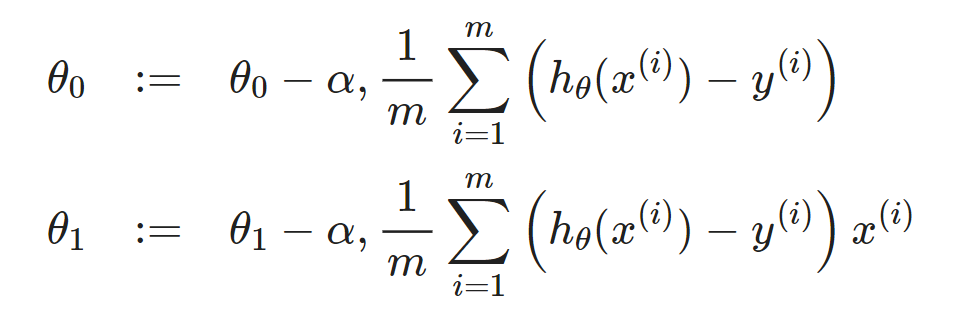

## 3. Reprezentacja graficzna regresji wielomianowej

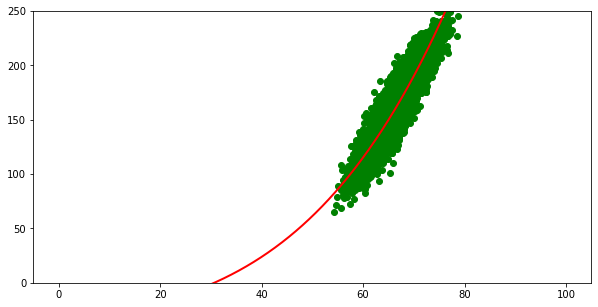

In [5]:
def plot_polynomial_regression(theta):
    fig = plt.figure(figsize=(10,5))
    Y_plot = polynomial_regression(theta, X_plot).tolist()
    chart = fig.add_subplot()
    chart.plot(data["Height"], Y ,"go")
    chart.plot(X_plot, Y_plot, color="red", lw=2, label=f"degree {len(theta)}")
    plt.ylim([0,250])
    plt.show()
    
#plot_polynomial_regression(initial_theta)
plot_polynomial_regression(final_theta)

In [28]:
for i,x in enumerate(final_theta.tolist()):
    x = x[0]
    print(f"{x}x^{i}", end=" + ")

-33.70007165990287x^0 + 36.22536357022561x^1 + 77.13438753083798x^2 + 97.31645980974973x^3 + 103.01308458334519x^4 + 

## 4. Regresja wielomianowa z wykorzystaniem gotowej biblioteki

In [7]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression

In [8]:
model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True), 
                       LinearRegression())
model.fit(data[["Height"]],Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

4

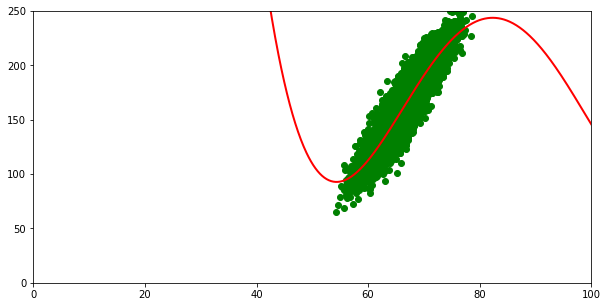

In [9]:
Y_plot_2 = model.predict([[x] for x in X_plot])

fig = plt.figure(figsize=(10,5))
chart = fig.add_subplot()
chart.plot(data["Height"], Y ,"go")
chart.plot(X_plot, Y_plot_2, color="red", lw=2, label=f"degree {degree}")
plt.ylim([0,250])
plt.xlim([0,100])
degree